# Text classification with an RNN

This is a text classification that uses recurrent neural network on the IMDB large movie review dataset for sentiment analysis.


_source_: https://www.tensorflow.org/text/tutorials/text_classification_rnn

_Tensorflow Version_: >= 2.6.0


Design of Bidirectional Model                                                         |                                       Design of Stack two or more LSTM layers
:------------------------------------------------------------------------------------:|:-----------------------------------------------------------------------------------------------------:
![bidirectional](https://www.tensorflow.org/text/tutorials/images/bidirectional.png)  |  ![layered_bidirectional](https://www.tensorflow.org/text/tutorials/images/layered_bidirectional.png)

In [4]:
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds

In [5]:
tfds.disable_progress_bar()

## Helpers functions

In [6]:
def plot_history_metric(history, metric):
    """
    Plot metric of model train by epochs history.
    """
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])

## Setup input pipeline

In [7]:
dataset, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True, shuffle_files=True)
train_dataset, test_dataset = dataset["train"], dataset["test"]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePTXSU0/imdb_reviews-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePTXSU0/imdb_reviews-test.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompletePTXSU0/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [19]:
train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

#### Take one text example and its label. 

In [20]:
example_text, example_label = None, None
for text, label in train_dataset.take(1):
    example_text = text.numpy()
    example_label = label.numpy()

__Text Example:__

In [21]:
print(example_text)

b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."


__Label Example:__

In [22]:
print(example_label)

0


## Shuffle the data for train and create batches of these (text, label) pairs

In [23]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [24]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [25]:
example_batch_texts, example_batch_labels = None, None,
for example, label in train_dataset.take(1):
    example_batch_texts = example.numpy()
    example_batch_labels = label.numpy()

__Batch Texts Example:__

In [26]:
print(example_batch_texts[:3])

[b'When I had first heard of "Solar Crisis" then got a load of the cast, I wondered why I had never heard of a movie with such a big cast before. Then I saw it.<br /><br />Now I know.<br /><br />For a movie that encompasses outer space, the sun, vast deserts and sprawling metropolises, this is an awfully cramped and claustrophobic feature; it feels like everyone is hunkered close together so the camera won\'t have to pull too far back.<br /><br />And the effects, while good, are pretty underwhelming; we\'re talking about the imminent destruction of the planet Earth if a team of scientists and soldiers cannot deflect a deadly solar flare. But other than shouting, sweating and a red glow about everything, there\'s no real feel of emergency.<br /><br />Don\'t get me started about the cast. What Heston, Palance, Matheson, Boyle, et al are doing in this movie without even bothering to act with any feel for the material is anyone\'s guess. Makes you wonder who else\'s condos aren\'t paid for

__Batch Labels Example:__

In [27]:
print(example_batch_labels[:3])

[0 0 1]


## Create the text encoder

In [28]:
VOCAB_SIZE = 1000

encoder_layer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder_layer.adapt(train_dataset.map(lambda text, label: text))

In [29]:
vocab = np.array(encoder_layer.get_vocabulary())

print(vocab[:15])

['' '[UNK]' 'the' 'and' 'a' 'of' 'to' 'is' 'in' 'it' 'i' 'this' 'that'
 'br' 'was']


In [30]:
encoded_example = encoder_layer(example)[:3].numpy()

print(encoded_example)

[[51 10 67 ...  0  0  0]
 [11  1  1 ...  0  0  0]
 [ 1 10 39 ...  0  0  0]]


In [31]:
for n in range(2):
    print("Original: ", example[n].numpy())
    print("--------------------------------")
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

Original:  b'When I had first heard of "Solar Crisis" then got a load of the cast, I wondered why I had never heard of a movie with such a big cast before. Then I saw it.<br /><br />Now I know.<br /><br />For a movie that encompasses outer space, the sun, vast deserts and sprawling metropolises, this is an awfully cramped and claustrophobic feature; it feels like everyone is hunkered close together so the camera won\'t have to pull too far back.<br /><br />And the effects, while good, are pretty underwhelming; we\'re talking about the imminent destruction of the planet Earth if a team of scientists and soldiers cannot deflect a deadly solar flare. But other than shouting, sweating and a red glow about everything, there\'s no real feel of emergency.<br /><br />Don\'t get me started about the cast. What Heston, Palance, Matheson, Boyle, et al are doing in this movie without even bothering to act with any feel for the material is anyone\'s guess. Makes you wonder who else\'s condos aren\'

## Create the model

In [33]:
embedding_layer = tf.keras.layers.Embedding(
    input_dim=len(encoder_layer.get_vocabulary()),
    output_dim=64,
    mask_zero=True)

In [34]:
model = tf.keras.Sequential([
    encoder_layer,
    embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [35]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


### Predict on a sample text without padding

In [36]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')

predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.00311613]


### Predict on a sample text with padding

In [37]:
padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.00311613]


### Compile the Keras model to configure the training process

In [38]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

## Train the model

In [24]:
history = model.fit(
    train_dataset, 
    epochs=10,
    validation_data=test_dataset,
    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 756s 2s/step - loss: 0.6199 - accuracy: 0.5944 - val_loss: 0.4632 - val_accuracy: 0.7578
Epoch 2/10
391/391 [==============================] - 738s 2s/step - loss: 0.3867 - accuracy: 0.8245 - val_loss: 0.3519 - val_accuracy: 0.8453
Epoch 3/10
391/391 [==============================] - 736s 2s/step - loss: 0.3321 - accuracy: 0.8544 - val_loss: 0.3345 - val_accuracy: 0.8464
Epoch 4/10
391/391 [==============================] - 735s 2s/step - loss: 0.3162 - accuracy: 0.8621 - val_loss: 0.3288 - val_accuracy: 0.8526
Epoch 5/10
391/391 [==============================] - 723s 2s/step - loss: 0.3091 - accuracy: 0.8654 - val_loss: 0.3384 - val_accuracy: 0.8573
Epoch 6/10
391/391 [==============================] - 728s 2s/step - loss: 0.3059 - accuracy: 0.8672 - val_loss: 0.3234 - val_accuracy: 0.8432
Epoch 7/10
391/391 [==============================] - 724s 2s/step - loss: 0.3024 - accuracy: 0.8680 - val_loss: 0.3208 - val_accuracy: 0.8615

In [27]:
test_loss, test_acc = model.evaluate(test_dataset)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

391/391 [==============================] - 153s 392ms/step - loss: 0.3150 - accuracy: 0.8532
Test Loss: 0.31503576040267944
Test Accuracy: 0.8532000184059143


(0.0, 0.6360699638724328)

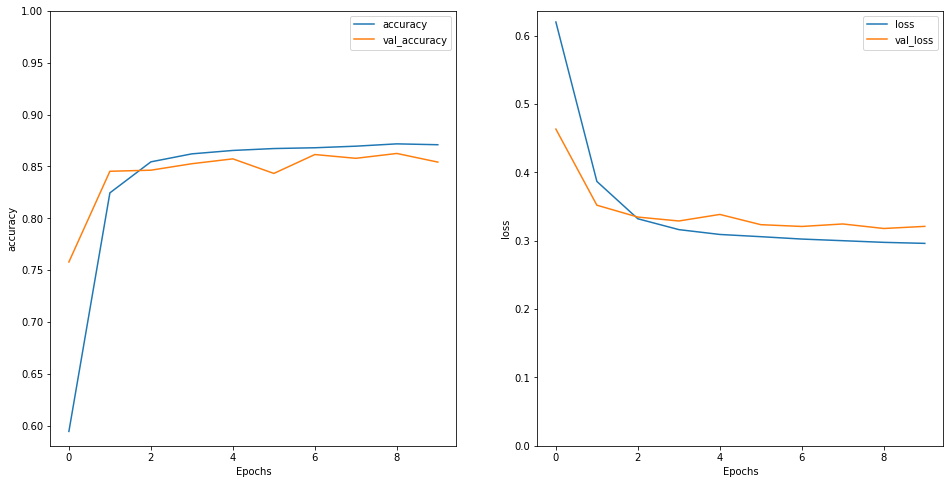

In [28]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_history_metric(history, 'accuracy')
plt.ylim(None, 1)

plt.subplot(1, 2, 2)
plot_history_metric(history, 'loss')
plt.ylim(0, None)

### Prediction on a new sentence

In [29]:
ample_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

print(predictions)

[[0.72040594]]


## Stack more two LSTM Layers

Set _return_sequences=True_ to generate sequences of successive outputs for each timestep (a 3D tensor of shape (batch_size, timesteps, output_features)).

In [39]:
many_outputs_model = tf.keras.Sequential([
    encoder_layer,
    tf.keras.layers.Embedding(len(encoder_layer.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [40]:
many_outputs_model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(1e-4),
    metrics=['accuracy']
)

In [42]:
many_outputs_history = many_outputs_model.fit(train_dataset, 
                                              epochs=10,
                                              validation_data=test_dataset,
                                              validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1432s 4s/step - loss: 0.6165 - accuracy: 0.5936 - val_loss: 0.4257 - val_accuracy: 0.7937
Epoch 2/10
391/391 [==============================] - 1381s 4s/step - loss: 0.3765 - accuracy: 0.8304 - val_loss: 0.3522 - val_accuracy: 0.8464
Epoch 3/10
391/391 [==============================] - 1369s 4s/step - loss: 0.3334 - accuracy: 0.8564 - val_loss: 0.3420 - val_accuracy: 0.8417
Epoch 4/10
391/391 [==============================] - 1378s 4s/step - loss: 0.3194 - accuracy: 0.8629 - val_loss: 0.3304 - val_accuracy: 0.8505
Epoch 5/10
391/391 [==============================] - 1374s 4s/step - loss: 0.3092 - accuracy: 0.8678 - val_loss: 0.3264 - val_accuracy: 0.8578
Epoch 6/10
391/391 [==============================] - 1374s 4s/step - loss: 0.3045 - accuracy: 0.8690 - val_loss: 0.3181 - val_accuracy: 0.8495
Epoch 7/10
391/391 [==============================] - 1376s 4s/step - loss: 0.3048 - accuracy: 0.8678 - val_loss: 0.3334 - val_accuracy:

In [50]:
many_outputs_test_loss, many_outputs_test_acc = many_outputs_model.evaluate(test_dataset)

print('Test Loss:', many_outputs_test_loss)
print('Test Accuracy:', many_outputs_test_acc)

391/391 [==============================] - 306s 783ms/step - loss: 0.3179 - accuracy: 0.8602
Test Loss: 0.3179045617580414
Test Accuracy: 0.8601599931716919


In [48]:
sample_text = ("The movie was not good. The animation and the graphics were terrible. I would not recommend this movie.")
predictions = many_outputs_model.predict(np.array([sample_text]))
print(predictions)

[[-1.6829077]]


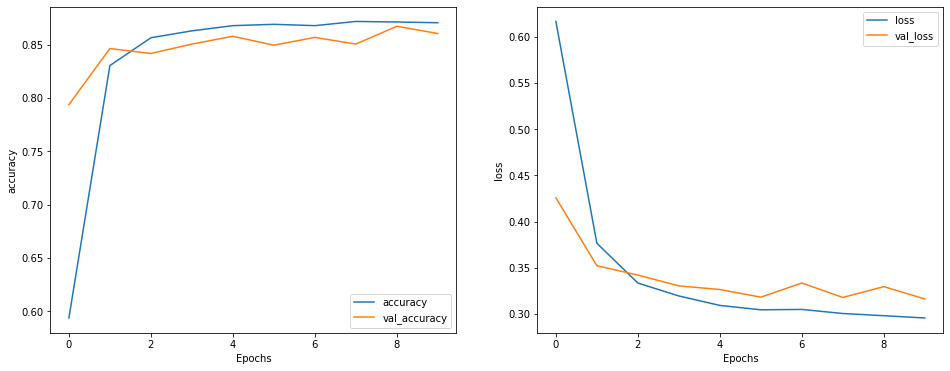

In [49]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_history_metric(many_outputs_history, 'accuracy')

plt.subplot(1, 2, 2)
plot_history_metric(many_outputs_history, 'loss')